In [1]:
!pip install opencv-python

In [9]:
!pip install tensorflow
!pip install numpy

# Libraries

In [10]:
# Display
import matplotlib.pyplot as plt
# Directory
import cv2
import os
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

# Loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Convert images to array of floats
import numpy as np

# GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

device = "/GPU:0"

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-12-04 16:26:40.831798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 16:26:42.731866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 16:26:42.735169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Display

In [11]:
# Display
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow((images[i].astype(as_type) + 1) / 2, cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


# Load Images Dataset

In [5]:
train = np.loadtxt("text_data/cat_data.txt")
train = train.reshape((29843, 64, 64, 3))
train.shape

(29843, 64, 64, 3)

In [12]:
display(train[:10])

ValueError: object __array__ method not producing an array

<Figure size 2000x300 with 10 Axes>

# Create Dataset

In [7]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(train[:29823])

KeyboardInterrupt: 

In [8]:
dataset = dataset.shuffle(29824)

In [9]:
dataset = dataset.batch(batch_size)
# Prefetch done so I don't need to wait as long
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# GAN Start

In [10]:
# Variables
channels = 3
img_size = 64
img_shape = train[0].shape

noise_dim = 100

dropout = 0.1

momentum = 0.5

epochs = 100
scale = 1

# Generator

In [11]:
class Generator(tf.keras.Model):
    def __init__(self, noise_dim, momentum):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.momentum = momentum

        # Define blocks (Currently using 4 major blocks)
        # Notes for self:
        #-When using leaky relu, 0.2 seems good for a GAN, since I am using negative 
        # input as well
        #-For batch normalization, numbers closer to 1 grab information from earlier 
        # back, which works well for stable data. I will use 0.85, since the cat picture
        # data is relatively stable.
        #-GANs for mnist (28, 28, 1) use 2-3 blocks, so I will use 4 blocks for my
        # larger images (64, 64, 3)
        #-Kernel of 5 since I want a lot of information, but I also want good effeciency

        self.dense1 = layers.Dense(4*4*256, input_shape=(self.noise_dim,))
        self.relu1 = layers.LeakyReLU(alpha=0.2) 
        self.batch_norm1 = layers.BatchNormalization(momentum=self.momentum)

        self.reshape = layers.Reshape((4, 4, 256)) # standard

        self.conv2d_2 = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", use_bias=False)
        self.relu2 = layers.LeakyReLU(alpha=0.2) 
        self.batch_norm2 = layers.BatchNormalization(momentum=self.momentum)

        self.conv2d_3 = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False)
        self.relu3 = layers.LeakyReLU(alpha=0.2) 
        self.batch_norm3 = layers.BatchNormalization(momentum=self.momentum)

        self.conv2d_4 = layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", use_bias=False)
        self.relu4 = layers.LeakyReLU(alpha=0.2) 
        self.batch_norm4 = layers.BatchNormalization(momentum=self.momentum)

        self.conv2d_final = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh", use_bias=False)

    def call(self, noise):
        x = self.dense1(noise)
        x = self.relu1(x)
        x = self.batch_norm1(x)
        x = self.reshape(x)

        x = self.conv2d_2(x)
        x = self.relu2(x)
        x = self.batch_norm2(x)

        x = self.conv2d_3(x)
        x = self.relu3(x)
        x = self.batch_norm3(x)

        x = self.conv2d_4(x)
        x = self.relu4(x)
        x = self.batch_norm4(x)

        imgs = self.conv2d_final(x)

        return imgs
    
    def generate(self, batch_size, noise):
        if noise is None:
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        return self.call(tf.convert_to_tensor(noise, tf.float32))
    

In [12]:
# Quick check
generator = Generator(noise_dim, momentum=momentum)
images = generator.generate(batch_size, None)

/home/dsu/genai/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dsu/genai/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-11-20 15:28:23.919377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


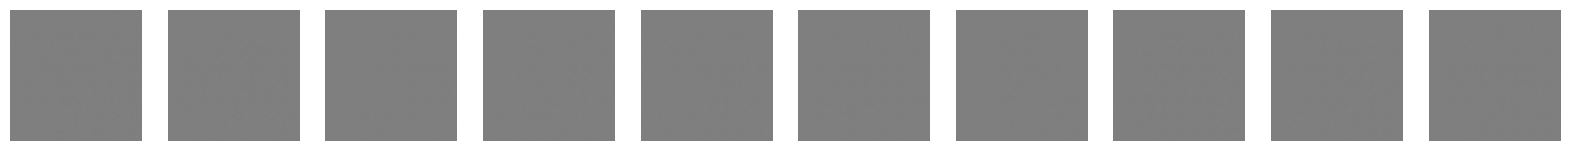

In [13]:
display(images.numpy()[:10])
# Yep that's noise

In [14]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (64, 4096)             │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (64, 4096)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (64, 4096)             │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (64, 4, 4, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (64, 8, 8, 128)        │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (64, 8, 8, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (64, 8, 8, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (64, 16, 16, 64)       │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (64, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (64, 16, 16, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (64, 32, 32, 32)       │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (64, 32, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (64, 32, 32, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (64, 64, 64, 3)        │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,508,576 (5.75 MB)

 Trainable params: 1,499,936 (5.72 MB)

 Non-trainable params: 8,640 (33.75 KB)

# Discriminator

In [15]:
class Discriminator(tf.keras.Model):
    def __init__(self, dropout):
        super(Discriminator, self).__init__()

        # 64*64*3 --> 32*32*64
        self.conv2d_1 = layers.Conv2D(64, kernel_size=5, strides=2, padding="same")
        self.relu1 = layers.LeakyReLU(alpha = 0.2)
        self.dropout1 = layers.Dropout(dropout)
        # 32*32*64 --> 16*16*128
        self.conv2d_2 = layers.Conv2D(128, kernel_size=5, strides=2, padding="same")
        self.relu2 = layers.LeakyReLU(alpha = 0.2) 
        self.dropout2 = layers.Dropout(dropout)
        # 16*16*128 --> 8*8*256
        self.conv2d_3 = layers.Conv2D(256, kernel_size=5, strides=2, padding="same")
        self.relu3 = layers.LeakyReLU(alpha = 0.2) 
        self.dropout3 = layers.Dropout(dropout)
        # 8*8*256 --> 4*4*512
        self.conv2d_4 = layers.Conv2D(512, kernel_size=5, strides=2, padding="same")
        self.relu4 = layers.LeakyReLU(alpha = 0.2) 
        self.dropout4 = layers.Dropout(dropout)

        self.flatten = layers.Flatten()

        self.dense = layers.Dense(1, activation='sigmoid')

 
    def call(self, inputs, training=False):
        x = self.conv2d_1(inputs)
        x = self.relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2d_2(x)
        x = self.relu2(x)
        x = self.dropout2(x, training=training)

        x = self.conv2d_3(x)
        x = self.relu3(x)
        x = self.dropout3(x, training=training)

        x = self.conv2d_4(x)
        x = self.relu4(x)
        x = self.dropout4(x, training=training)

        x = self.flatten(x)
        
        return self.dense(x)

In [16]:
# Quick check
discriminator = Discriminator(dropout)
print(discriminator(images[:10]))

tf.Tensor(
[[0.499844  ]
 [0.4999473 ]
 [0.49988684]
 [0.49985722]
 [0.49998283]
 [0.49988666]
 [0.49991265]
 [0.49994373]
 [0.49991596]
 [0.49989262]], shape=(10, 1), dtype=float32)


In [17]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (10, 32, 32, 64)       │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (10, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (10, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (10, 16, 16, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (10, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (10, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (10, 8, 8, 256)        │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (10, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (10, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (10, 4, 4, 512)        │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (10, 4, 4, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (10, 4, 4, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (10, 8192)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (10, 1)                │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

# Setup losses

In [18]:
# Discriminator trains too fast, even with dropout. Let's slow it down.
gen_adam = Adam(learning_rate=0.0001)
dis_adam = Adam(learning_rate=0.000005)# 0.000005
gen_loss = BinaryCrossentropy()
dis_loss = BinaryCrossentropy()

# Note: Tricking the discriminator with dropout, slower learning rate, and applying
# noise in the loss phase

# Build actual GAN

In [19]:
class CatGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, scale, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.scale = scale

    def compile(self, gen_adam, dis_adam, gen_loss, dis_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_adam = gen_adam
        self.dis_adam = dis_adam
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss

    def train_step(self, batch):
        # Real images
        real_images = batch
        # Generator_images
        fake_images = self.generator.generate(batch_size, None)

        # Train discriminator
        with tf.GradientTape() as dis_tape:
            # Discriminator guesses
            ycat_real = self.discriminator(real_images)
            ycat_fake = self.discriminator(fake_images)
            ycat_realfake = tf.concat([ycat_real, ycat_fake], axis=0)
            # Ground truth labels (0 is real, 1 is fake)
            labels_realfake = tf.concat([tf.zeros_like(ycat_real), tf.ones_like(ycat_fake)], axis=0)

            # Add noise to trick the discriminator
            # Real gets closer to fake, fake gets closer to real
            noise_real = self.scale * 0.15 * tf.random.uniform(tf.shape(ycat_real))
            noise_fake = self.scale * -0.15 * tf.random.uniform(tf.shape(ycat_fake))
            labels_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Get loss
            total_dis_loss = self.dis_loss(labels_realfake, ycat_realfake)

        # Now for backprop
        dis_grad = dis_tape.gradient(total_dis_loss, self.discriminator.trainable_variables)
        self.dis_adam.apply_gradients(zip(dis_grad, self.discriminator.trainable_variables))

        with tf.GradientTape() as gen_tape:
            # Generated images
            gen_images = self.generator.generate(batch_size, None)
            # Labels
            pred_labels = self.discriminator(gen_images, training=False)
            # Loss
            total_gen_loss = self.gen_loss(tf.zeros_like(pred_labels), pred_labels)


        # Now for backprop
        gen_grad = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.gen_adam.apply_gradients(zip(gen_grad, self.generator.trainable_variables))

        return {"dis_loss":total_dis_loss, "gen_loss":total_gen_loss}

In [20]:
catGAN = CatGAN(generator, discriminator, scale)
catGAN.compile(gen_adam, dis_adam, gen_loss, dis_loss)

In [21]:
from tensorflow.keras.preprocessing.image import array_to_img


for epoch in range(epochs):
    with tf.device(device):
        for batch in dataset:
            catGAN.train_step(batch)
    with tf.device("/CPU:0"):
        if(epoch % 10 == 0):
            print(epoch)
            # display 10 images
            tempImgs = catGAN.generator.generate(batch_size, None)
            display(tempImgs.numpy()[:10])
            # save image
            img = ((tempImgs[0] + 1) / 2) * 255
            img = img.numpy()
            img = array_to_img(img)
            img.save(os.path.join("text_data", "img_" + str(epoch / 10) + ".png"))

#display(catGAN.generator.generate(batch_size, None).numpy()[:10])


In [22]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    "checkpoint/model_checkpoint_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_best_only = False,
    verbose=1
)

class ModelMonitor(Callback):
    def __init__(self, catGAN):
        self.catGAN = catGAN

    def on_epoch_end(self, epoch, logs=None):
        # update scale
        #self.catGAN.scale = 1 - (epoch / epochs)
        # generate image
        if epoch % 1 == 0:
            gen_imgs = self.catGAN.generator.generate(batch_size, None)
            img = ((gen_imgs[0] + 1) / 2) * 255
            img = img.numpy()
            img = array_to_img(img)
            img.save(os.path.join("text_data", "img_" + str(epoch / 10) + ".png"))
        


In [23]:
hist = catGAN.fit(dataset, epochs=epochs, callbacks=[ModelMonitor(catGAN), checkpoint_cb])

Epoch 1/100


2024-11-20 15:28:29.680649: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2931720192 exceeds 10% of free system memory.
I0000 00:00:1732138116.507484   14358 service.cc:145] XLA service 0x7cb8c4015100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732138116.507582   14358 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
W0000 00:00:1732138116.723241   14358 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1/RandomUniform
2024-11-20 15:28:36.907629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  5/466 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - dis_loss: 0.6846 - gen_loss: 0.6924 

I0000 00:00:1732138124.869496   14358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - dis_loss: 0.5066 - gen_loss: 0.9763
Epoch 1: saving model to checkpoint/model_checkpoint_01.weights.h5
466/466 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - dis_loss: 0.5065 - gen_loss: 0.9759
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - dis_loss: 0.5589 - gen_loss: 1.0088
Epoch 2: saving model to checkpoint/model_checkpoint_02.weights.h5
466/466 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - dis_loss: 0.5590 - gen_loss: 1.0088
Epoch 3/100
465/466 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - dis_loss: 0.6026 - gen_loss: 0.9388
Epoch 3: saving model to checkpoint/model_checkpoint_03.weights.h5
466/466 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - dis_loss: 0.6030 - gen_loss: 0.9385
Epoch 4/100
465/466 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - dis_loss: 0.6460 - gen_loss: 0.7727
Epoch 4: saving model to checkpoint/model_checkpoint_04.weights.h5
466/466 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - dis_loss: 0.6460 - gen_loss: 0.7715
Epoch 5/100
465/466 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste

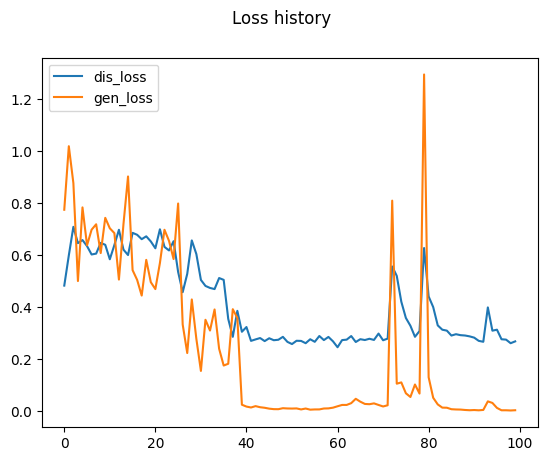

In [24]:
plt.suptitle("Loss history")
plt.plot(hist.history["dis_loss"], label="dis_loss")
plt.plot(hist.history["gen_loss"], label="gen_loss")
plt.legend()
plt.show()

In [25]:
catGAN.save("first_model.keras")

/home/dsu/genai/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


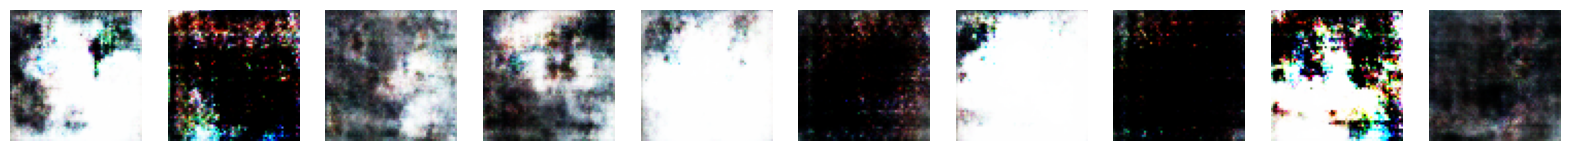

In [26]:
imgs = catGAN.generator.generate(batch_size, None)
display(imgs.numpy()[:10])

In [29]:
recon = CatGAN(generator, discriminator, scale)
recon.load_weights('checkpoint/model_checkpoint_30.weights.h5')

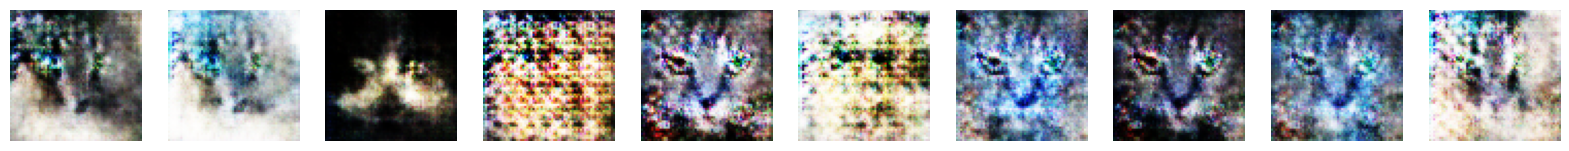

In [30]:
batch = recon.generator.generate(batch_size, None)
display(batch.numpy()[:10])